In [1]:
from PIL import Image
import kagglehub
import numpy as np
import os
import random

def train_test_split(path, split=0.75, max=None):
    items = [f"{path}/{i}" for i in os.listdir(path) if "png" in i]
    items = items[:max] if max is not None else items
    random.shuffle(items)
    split_index = int(len(items) * split)
    train, test = items[:split_index], items[split_index:]
    return train, test


def csv_loader(path):
    coords = []
    with open(path) as f:
        lines = f.readlines()

    for line in lines:
        lat, lng = line.strip().split(",")
        coords.append([float(lat), float(lng)])

    return coords


# 10,000 images, zero-indexed.png
path = kagglehub.dataset_download("paulchambaz/google-street-view")
path = f"{path}/dataset"

coords = csv_loader(f"{path}/coords.csv")

print(f"{len(coords)} coordinates loaded (lat, lng)")

train, test = train_test_split(path, split=0.75)
print(f"{len(train)} images for train, {len(test)} images for test")

/Users/flatypus/Documents/stanford/cs109/challenge/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


10000 coordinates loaded (lat, lng)
7500 images for train, 2500 images for test


In [ ]:
# I call the inputs (incoming nodes) 'x', and outgoing (nodes that I affect) 'o'

class Layer():
    compiled = False
    len = None
    x = None
    o = None
    
    def compile(self, inputs: int = None):
        if self.len is None:
            if inputs is None:
                raise Exception("The layer has an undefined size")
            self.len = inputs
        self.compiled = True
    
    def loss(self, lr):
        pass

    def __len__(self):
        return self.len
        
# ReLU and LeakyReLU together
class ReLU(Layer):
    def __init__(self, c=0):
        self.c = c

    def forward(self, x):
        self.x = x
        self.o = np.where(x > 0, x, self.c * x)
        return self.o
    
    def backward(self, dl):
        return dl * np.where(self.x > 0, 1, self.c)


class Sigmoid(Layer):
    def forward(self, x):
        self.x = x
        self.o = 1 / (1 + np.exp(-x))
        return self.o
    
    def backward(self, dl):
        return dl * self.o * (1 - self.o)


class PatchLinear(Layer):
    def __init__(self, outputs, wpn):
        self.len = outputs
        self.wpn = wpn

    def compile(self, _=None):
        if _ is not None:
            raise Exception("This layer must be the first layer")
            
        self.weights = np.random.randn(self.len, self.wpn) / np.sqrt(self.wpn) # N x Inputs
        self.bias = np.zeros(self.len)  # N x 1
        self.compiled = True

    def forward(self, x):
        self.x = x
        self.o = []
        for patch, weights in zip(x, self.weights):
            self.o.append(patch.T @ weights)  # dot product, returns float
        return np.array(self.o) + self.bias

    def backward(self, dl):
        self.dW = np.zeros_like(self.weights)
        self.db = np.zeros_like(self.bias)
        dx = np.zeros_like(self.x) 

        for i, (patch, w) in enumerate(zip(self.x, self.weights)):
            self.dW[i] = dl[i] * patch
            self.db[i] = dl[i]
            dx[i] = dl[i] * w
        return dx

    def loss(self, lr):
        self.weights -= lr * self.dW
        self.bias -= lr * self.db

    def __repr__(self):
        return f"Patch Linear layer, with {self.wpn} weights per neuron and {self.len} outputs"


class Dense(Layer):
    def __init__(self, outputs):
        self.len = outputs

    def compile(self, inputs):
        if inputs is None and self.inputs is None:
            raise Exception("This layer has an undefined size")
        self.inputs = inputs
        self.weights = np.random.randn(self.len, inputs) / np.sqrt(inputs) # N x Inputs
        self.bias = np.zeros(self.len) # N x 1
        self.compiled = True

    def forward(self, x):
        self.x = x
        self.o = self.weights @ x + self.bias
        return self.o
            
    def backward(self, dl):
        self.dW = np.outer(dl, self.x) # (N) x (Inputs)
        self.db = dl # x 1
        return self.weights.T @ dl
    
    def loss(self, lr):
        self.weights -= lr * self.dW
        self.bias -= lr * self.db

        
    def __repr__(self):
        return f"Dense layer, with {self.inputs} inputs and {self.len} outputs"

class Softmax(Layer):
    def forward(self, x):
        self.x = x
        x_shift = x - np.max(x)
        exp = np.exp(x_shift)
        self.o = exp / np.sum(exp)
        return self.o

    def backward(self, dl):
        return dl # handled in the train loop

In [3]:
from typing import List
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

class Model:
    def __init__(self):
        self.layers: List[Layer] = []

    def sigmoid(self):
        self.layers.append(Sigmoid())
        return self
    
    def relu(self):
        self.layers.append(ReLU())
        return self

    def leaky_relu(self, c: float):
        self.layers.append(ReLU(c=c))
        return self
    
    def patch_linear(self, outputs, wpn):
        self.layers.append(PatchLinear(outputs, wpn))
        return self

    def dense(self, outputs):
        self.layers.append(Dense(outputs))
        return self

    def softmax(self):
        self.layers.append(Softmax())
        return self
    
    def compile(self):
        inputs = None
        for layer in self.layers:
            layer.compile(inputs)
            inputs = len(layer)

    def train(self, data_gen, correct, lr=0.001, epochs=100):
        for epoch in range(epochs):
            loss_sum = 0
            best_loss = float("inf")
            best_source = None
            best_target = None
            best_inputs = None
            for index, inputs in tqdm(enumerate(data_gen()), total=len(correct), desc=f"Epoch {epoch + 1}/{epochs}"):
                target = correct[index]
                source = train[index]
                if len(self.layers) == 0:
                    raise Exception("No layers to train")

                if inputs.shape[0] != len(self.layers[0]):
                    raise Exception("Data/input-layer shape mismatch")

                # forward pass
                for layer in self.layers:
                    if not layer.compiled:
                        raise Exception("Please compile your layers!")
                    inputs = layer.forward(inputs)

                if inputs.shape != target.shape:
                    raise Exception("Output-layer/target shape mismatch")

                epsilon = 1e-12
                loss = -(target * np.log(inputs + epsilon)).sum()

                loss_sum += loss
                if loss < best_loss:
                    best_source = source
                    best_target = target
                    best_inputs = inputs
                    best_loss = loss

                # backwards pass
                dl = inputs - target
                for index in range(len(self.layers) - 1, -1, -1):
                    layer = self.layers[index]
                    dl = layer.backward(dl)

                # update loss on weights
                for layer in self.layers:
                    layer.loss(lr)

            print(f"Epoch {epoch + 1}/{epochs}; avg loss:", loss_sum / len(correct))
            plt.imshow(best_target.reshape(16, 32), cmap='hot', origin='lower')
            plt.title("TARGET CORRECT")
            plt.show()
            plt.title(f"MODEL GUESS (loss: {best_loss})")
            plt.imshow(best_inputs.reshape(16, 32), cmap='hot', origin='lower')
            plt.show()
            plt.title(f"REAL IMAGE")
            plt.imshow(Image.open(best_source))
            plt.show()

    def log(self):
        for layer in self.layers:
            print(layer)

In [4]:
OUT_H, OUT_W = 16, 32

model = (
    Model()
    .patch_linear(400, wpn=3072)  # 20 x 20 patches, 3072 weights per neuron
    .relu()
    .dense(320)
    .relu()
    .dense(OUT_H * OUT_W) # broadcast back up to heatmap coordinates
    .softmax()
)

model.compile()
model.log()

Patch Linear layer, with 3072 weights per neuron and 400 outputs
Dense layer, with 400 inputs and 320 outputs
Dense layer, with 320 inputs and 512 outputs


Epoch 1/50: 100%|██████████| 7500/7500 [01:51<00:00, 67.17it/s]


Epoch 1/50; avg loss: 5.7516106352439005


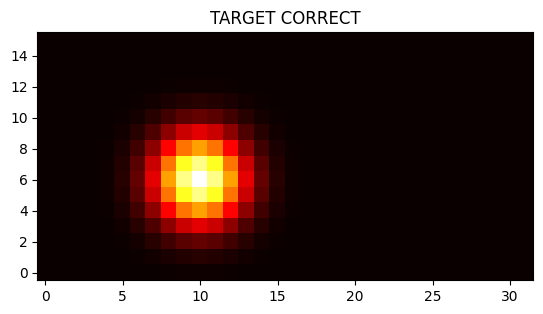

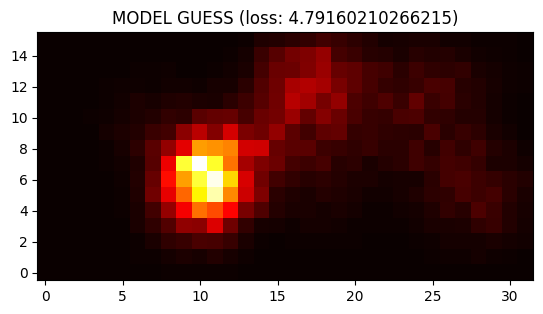

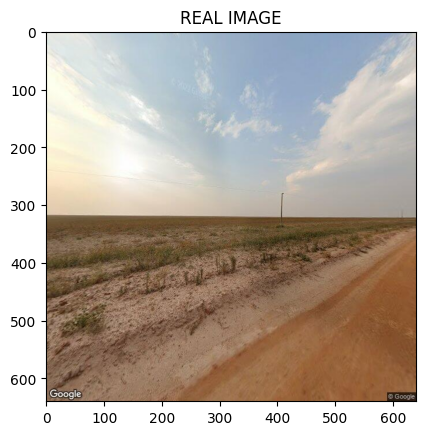

Epoch 2/50: 100%|██████████| 7500/7500 [01:52<00:00, 66.44it/s]


Epoch 2/50; avg loss: 5.694109890265995


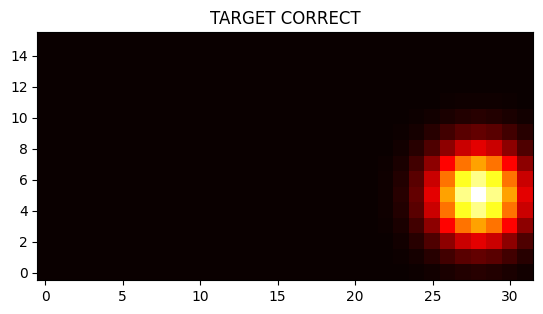

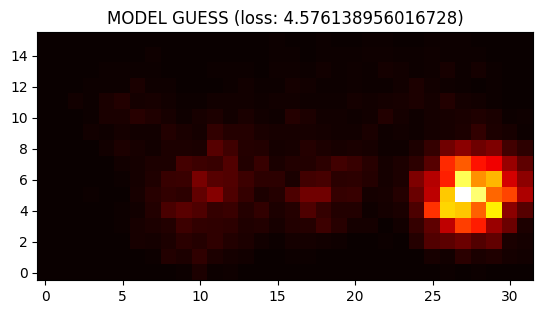

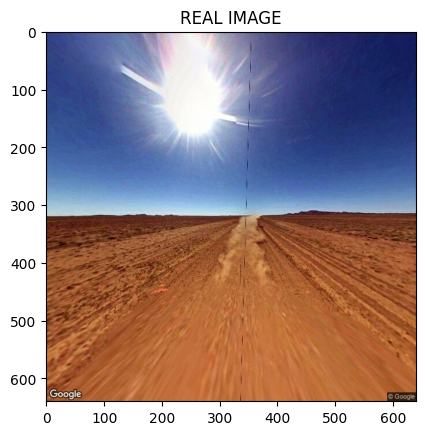

Epoch 3/50: 100%|██████████| 7500/7500 [01:52<00:00, 66.50it/s]


Epoch 3/50; avg loss: 5.670482571161322


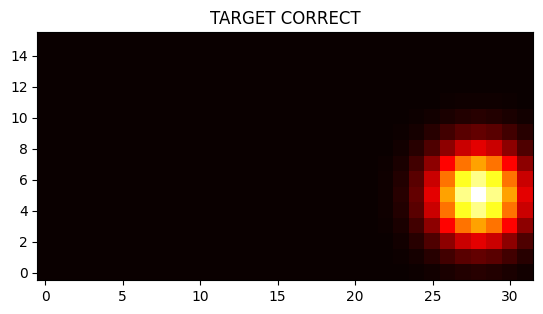

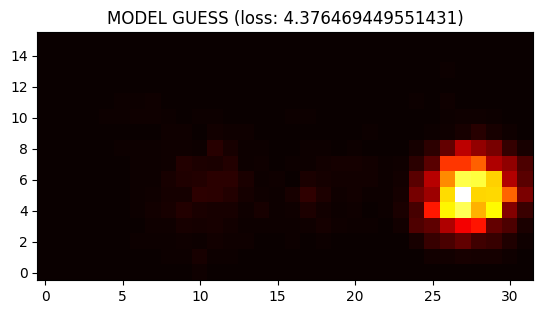

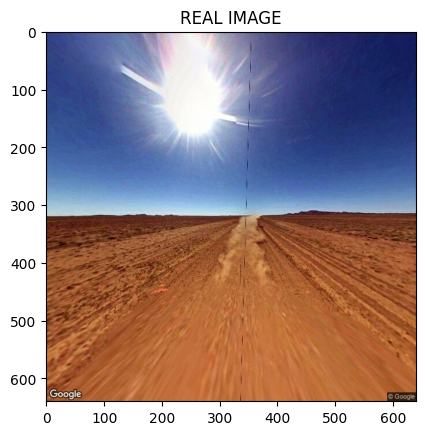

Epoch 4/50: 100%|██████████| 7500/7500 [01:41<00:00, 73.96it/s]


Epoch 4/50; avg loss: 5.651463230691817


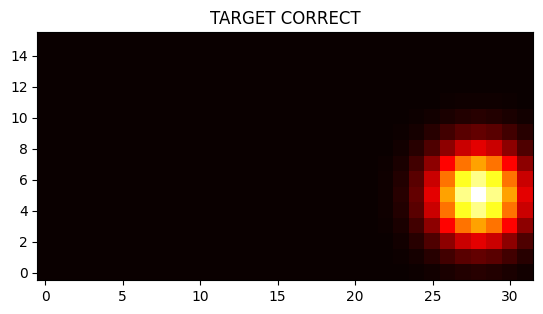

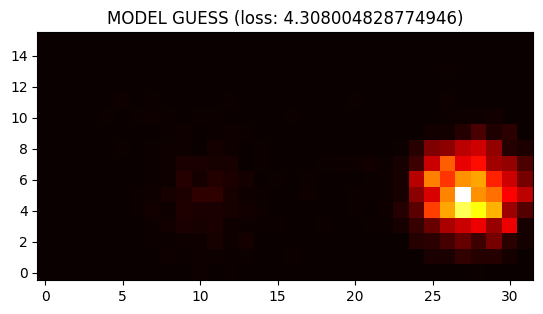

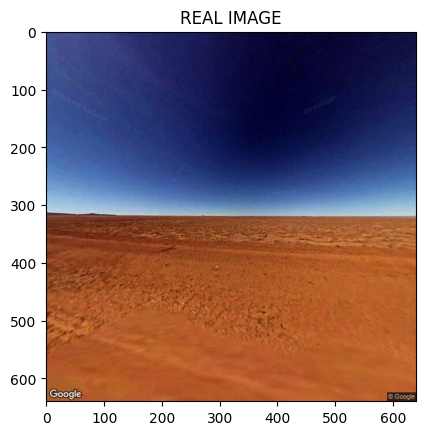

Epoch 5/50: 100%|██████████| 7500/7500 [01:49<00:00, 68.70it/s]


Epoch 5/50; avg loss: 5.634567502159022


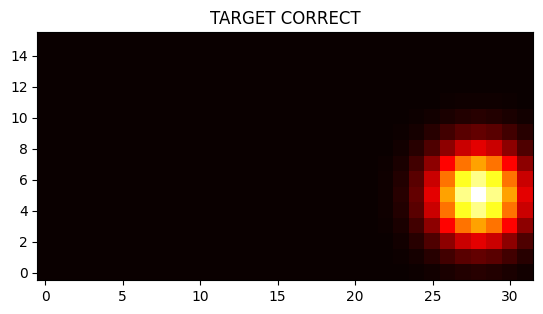

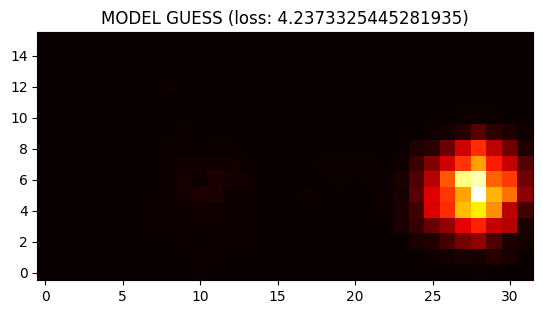

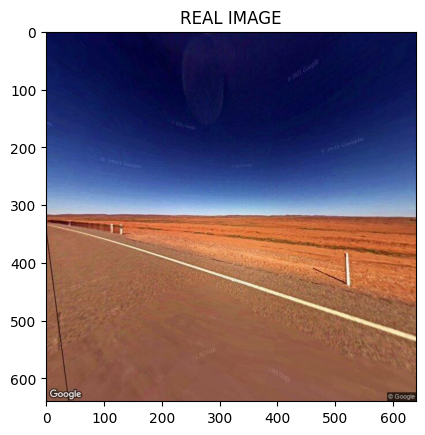

Epoch 6/50:  43%|████▎     | 3242/7500 [00:46<01:16, 55.67it/s]

In [ ]:
def load_imgs(images):
    def gen():
        for img_path in images:
            yield format_frame(np.asarray(Image.open(img_path)))
    return gen


def load_correct(images, height, width, sigma=1.0):
    images = [image.split("/")[-1] for image in images]
    indices = [int(image.split(".")[0]) for image in images]
    positions = [coords[index] for index in indices]
    correct = []
    for lat, lng in positions:
        array = np.zeros((height, width))
        lat_index = int((lat + 90) / 180 * height)
        lat_index = min(height - 1, lat_index)
        lon_index = int((lng + 180) / 360 * width)
        lon_index = min(width - 1, lon_index)
        for y in range(height):
            for x in range(width):
                # gaussian distribution for heatmap
                dist = (x - lon_index)**2 + (y - lat_index)**2
                array[y, x] = np.exp(-dist / (2 * sigma**2))
        array = array.flatten()
        normalized = array / array.sum()
        correct.append(normalized)
    return np.array(correct)

# Need data in the right shape
# Incoming: [640, 640, 3] 
# Returns: -> [3 x 640 x 640]
def format_frame(frame, patch_size=32):
    H, W, C  = frame.shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    # this took SO much experimentation, but you need to do this to ensure the patches are preserved
    frame = frame.reshape(num_patches_h, patch_size, num_patches_w, patch_size, 3)
    frame = frame.transpose(0, 2, 1, 3, 4)
    frame = frame.reshape(-1, patch_size, C)
    frame = frame.transpose(2, 0, 1)
    frame = frame.reshape(num_patches_h * num_patches_w, -1)
    return frame / 255.0  # normalize to 0-1


train_image_loader = load_imgs(train)
train_correct = load_correct(train, OUT_H, OUT_W, sigma=2)
model.train(data_gen=train_image_loader, correct=train_correct, lr=0.01, epochs=50)